In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, RocCurveDisplay
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")


# Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISDS_take_home_assignment_prediction_data.csv')

In [21]:
cols_to_clean = ['Hypothension', 'Family_history_of_MI', 'Time_To_Relief']
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [22]:
df['Killip_class'] = df['Killip_class'].replace(-1, np.nan)

In [23]:
target = 'Day30_mortality'
X = df.drop(columns=[target])
y = df[target]

print(f"Data Loaded: {df.shape[0]} patients, {df[target].sum()} deaths ({df[target].mean():.1%})")
print(f"Missing values detected and handled: {df.isnull().sum().sum()}")

Data Loaded: 785 patients, 52 deaths (6.6%)
Missing values detected and handled: 24


##EXPLORATORY DATA ANALYSIS


--- EDA Plots Generated (Saved as eda_plots.png) ---


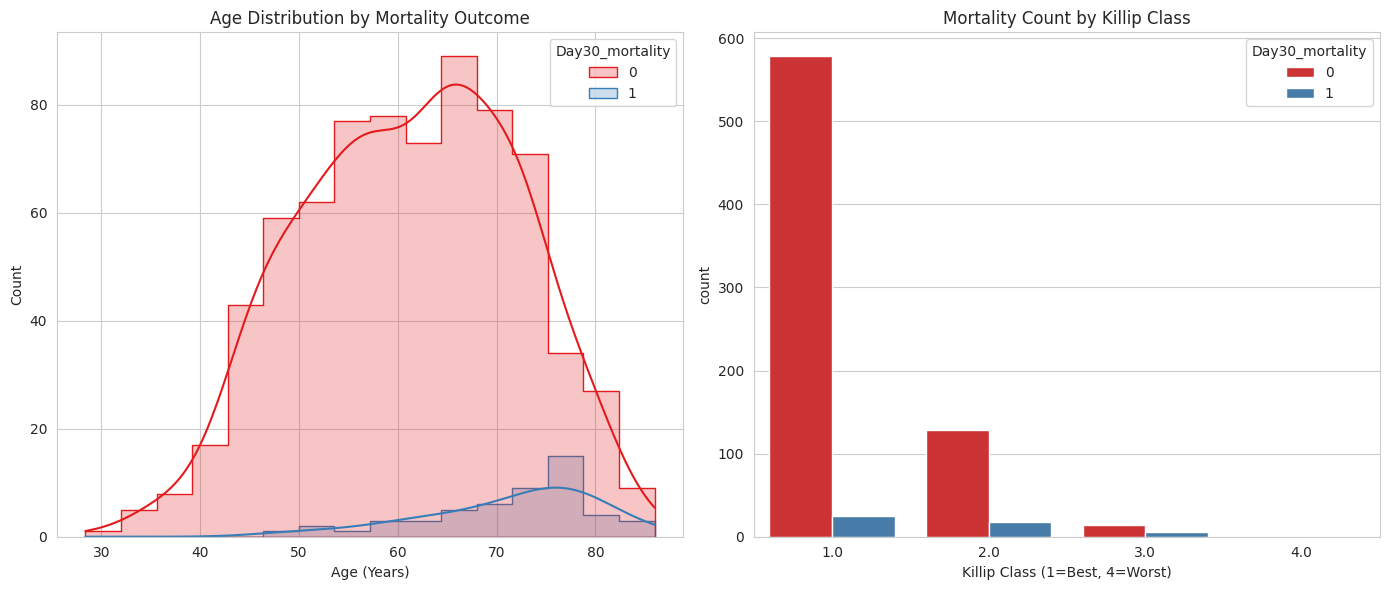

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot A: Age Distribution by Survival
sns.histplot(data=df, x='Age', hue=target, kde=True, element="step", ax=axes[0], palette='Set1')
axes[0].set_title("Age Distribution by Mortality Outcome")
axes[0].set_xlabel("Age (Years)")

# Plot B: Killip Class Count
sns.countplot(data=df, x='Killip_class', hue=target, ax=axes[1], palette='Set1')
axes[1].set_title("Mortality Count by Killip Class")
axes[1].set_xlabel("Killip Class (1=Best, 4=Worst)")

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=300) # Save for Report
print("\n--- EDA Plots Generated (Saved as eda_plots.png) ---")
plt.show()

In [25]:
print("\n--- TABLE 1: Baseline Characteristics (Stratified by Outcome) ---")
# We group by the outcome to show the difference between Survivors (0) and Died (1)
table1 = df.groupby(target).agg(['mean', 'std', 'count']).T
# Display first 10 rows of Table 1 (Copy this into your report!)
display(table1.head(10))


--- TABLE 1: Baseline Characteristics (Stratified by Outcome) ---


Day30_mortality              0          1
Gender       mean     0.253078   0.346154
             std      0.435073   0.480384
             count  731.000000  52.000000
Age          mean    61.133122  71.540058
             std     10.959664   8.718121
             count  732.000000  52.000000
Killip_class mean     1.216667   1.660000
             std      0.457057   0.772222
             count  720.000000  50.000000
Diabetes     mean     0.103683   0.173077

##PIPELINE

In [26]:
numeric_features = ['Age', 'Height', 'Weight', 'Heart_rate', 'Systolic_BP', 'Time_To_Relief']
# Check if columns exist (handle typo in original CSV 'Hyperthension')
numeric_features = [c for c in numeric_features if c in X.columns]
if 'Hyperthension' in X.columns: numeric_features.append('Hyperthension') # Handle typo

In [27]:
# 1. Heart Rate is Binary (0=Normal, 1=Tachycardia)
# We calculate the percentage (%) of people with Tachycardia in each group
hr_stats = df.groupby('Day30_mortality')['Heart_rate'].mean() * 100
print(f"Tachycardia (>80 bpm) - Survivors:     {hr_stats[0]:.1f}%")
print(f"Tachycardia (>80 bpm) - Non-Survivors: {hr_stats[1]:.1f}%")

# We calculate the percentage (%) of people with Hypotension
col_name = 'Hypothension' if 'Hypothension' in df.columns else 'Hypotension'

hypo_stats = df.groupby('Day30_mortality')[col_name].mean() * 100
print(f"Hypotension (<100 mmHg) - Survivors:     {hypo_stats[0]:.1f}%")
print(f"Hypotension (<100 mmHg) - Non-Survivors: {hypo_stats[1]:.1f}%")

Tachycardia (>80 bpm) - Survivors:     24.8%
Tachycardia (>80 bpm) - Non-Survivors: 51.9%
Hypotension (<100 mmHg) - Survivors:     4.8%
Hypotension (<100 mmHg) - Non-Survivors: 9.6%


In [28]:
categorical_features = [c for c in X.columns if c not in numeric_features]

In [29]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical -> Impute Mode -> OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [30]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

##ROBUST VALIDATION (Cross-Validation)

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['roc_auc', 'neg_brier_score']
scores = cross_validate(lr_model, X, y, cv=cv, scoring=scoring, return_train_score=False)

print("\n--- MODEL PERFORMANCE (5-Fold CV) ---")
print(f"Mean AUC-ROC:    {scores['test_roc_auc'].mean():.3f} (Wait for > 0.70)")
print(f"Mean Brier Score: {-scores['test_neg_brier_score'].mean():.3f} (Lower is better)")


--- MODEL PERFORMANCE (5-Fold CV) ---
Mean AUC-ROC:    0.758 (Wait for > 0.70)
Mean Brier Score: 0.169 (Lower is better)


In [32]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])
rf_scores = cross_validate(rf_model, X, y, cv=cv, scoring='roc_auc')
print(f"Random Forest AUC: {rf_scores['test_score'].mean():.3f}")
print("(If RF is not significantly better, stick to Logistic Regression for TRIPOD interpretability)")

Random Forest AUC: 0.768
(If RF is not significantly better, stick to Logistic Regression for TRIPOD interpretability)


##MODEL SPECIFICATION

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'Heart_rate',
                                                   'Time_To_Relief',
                                                   'Hyperthension']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gender', 'Killip_class',
                                                   'Diabetes', 'Hypothension',
                                                   'Anterior_infarct_location',
                                                   'Previous_myocardial_infarction',
                                                   'Smoking',
                                                   'Hypercholesterolaemia',
                                                   'Previous_angina_pectoris',
                                                   'Family_history_of_MI',
                                                   'ST_elevation_leads'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [34]:
# Get all feature names after preprocessing
all_feat = lr_model.named_steps['preprocessor'].get_feature_names_out()
coeffs = lr_model.named_steps['classifier'].coef_[0]

In [35]:
coef_df = pd.DataFrame({'Feature': all_feat, 'Beta': coeffs, 'OR': np.exp(coeffs)})
coef_df = coef_df.sort_values(by='OR', ascending=False)
print("\n--- TOP PREDICTORS (Odds Ratios) ---")
display(coef_df.head(10))


--- TOP PREDICTORS (Odds Ratios) ---


,Feature,Beta,OR
19,cat__ST_elevation_leads_1.0,1.778874,5.923183
9,cat__Killip_class_4.0,1.548783,4.705742
13,cat__Previous_myocardial_infarction_1.0,1.046451,2.847526
0,num__Age,0.772964,2.166177
7,cat__Killip_class_2.0,0.759240,2.136652
23,cat__ST_elevation_leads_5.0,0.580479,1.786894
3,num__Heart_rate,0.572709,1.773064
12,cat__Anterior_infarct_location_1.0,0.571705,1.771284
20,cat__ST_elevation_leads_2.0,0.515987,1.675291
10,cat__Diabetes_1.0,0.476384,1.610242


##ROC & Calibration

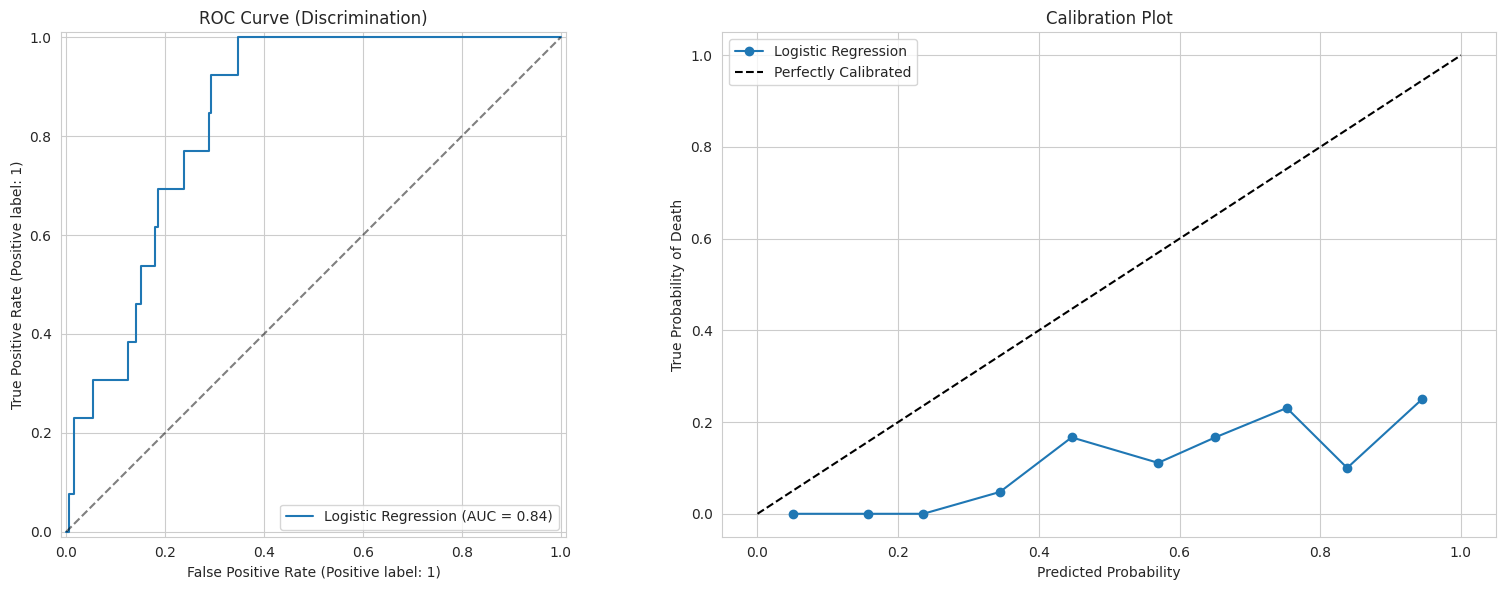

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve

# 1. Fit the model on the split to ensure we have a trained version for plotting
# (Ensure X_train, y_train are defined from previous steps)
lr_model.fit(X_train, y_train);

# 2. Create the Figure and Axes objects in the SAME CELL
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot A: ROC Curve (Left) ---
RocCurveDisplay.from_estimator(lr_model, X_test, y_test, ax=ax[0], name="Logistic Regression")
ax[0].plot([0, 1], [0, 1], "k--", alpha=0.5) # Diagonal line
ax[0].set_title("ROC Curve (Discrimination)")
ax[0].grid(True)

# --- Plot B: Calibration Curve (Right) ---
# Get probabilities for the positive class (death)
y_prob = lr_model.predict_proba(X_test)[:, 1]

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Plot it
ax[1].plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
ax[1].plot([0, 1], [0, 1], "k--", label='Perfectly Calibrated')
ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("True Probability of Death")
ax[1].set_title("Calibration Plot")
ax[1].legend()
ax[1].grid(True)

# 3. Show the final plot
plt.tight_layout()
plt.show()